# Customer Segmentation

In this project, we're exploring how people spend money to create personalised cashback offers. By understanding customers habits we can segment into categories and identify where they are likely to spend. Offering cashback on these purchases not only saves customers money but also boosts their satisfaction. For businesses, we offer a platform where they can drive sales through targeting both new and loyal customers alike.

## Data Treatment

In [470]:
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [471]:
# Main dataset
dataset_df = pd.read_csv("2nd Dataset - simulated_transaction_2024 v2.csv", index_col=0)
dataset_df.columns = dataset_df.columns.str.lower().str.replace(' ', '_').str.replace('/', '_')
dataset_df

,date,timestamp,account_no,balance,amount,third_party_account_no,third_party_name,in_out
0,01/01/2023,00:00,678330503.0,2971.000000,1584.00,NaN,Westport Care Home,in
1,01/01/2023,00:00,472213568.0,3792.000000,1950.00,NaN,Barbiee Boutique,in
2,01/01/2023,00:00,472213568.0,3012.000000,-780.00,283027736.0,NaN,out
3,01/01/2023,00:00,283027736.0,1787.000000,780.00,472213568.0,NaN,in
4,01/01/2023,00:00,624500124.0,3226.000000,1825.00,NaN,Fat Face,in
...,...,...,...,...,...,...,...,...
230591,06/12/2023,20:54,581655972.0,45935.206860,-41.06,NaN,Tesco,out
230592,06/12/2023,20:55,786141370.0,-244.837500,-62.35,NaN,Sainsbury Local,out
230593,06/12/2023,21:05,824916823.0,9709.172159,-32.94,NaN,Deliveroo,out
230594,06/12/2023,21:13,366550080.0,26834.165790,-19.25,NaN,Amazon,out


In [472]:
# Types and blank values
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230596 entries, 0 to 230595
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   date                    230367 non-null  object 
 1   timestamp               230345 non-null  object 
 2   account_no              230372 non-null  float64
 3   balance                 230350 non-null  float64
 4   amount                  230387 non-null  float64
 5   third_party_account_no  6832 non-null    float64
 6   third_party_name        223517 non-null  object 
 7   in_out                  230596 non-null  object 
dtypes: float64(4), object(4)
memory usage: 15.8+ MB


To start we need to clean the data and remove missing values.

On excel we added a column called "in_out" to separate incomings from outgoings

Furthermore we will need to remove missing values from the columns:
- <em>date</em>
- <em>account_no</em>
- <em>balance</em>
- <em>amount</em>
- <em>third_part_name</em>; only in case it meets two conditions: a) outgoing transaction, b) not a transfer between accounts
<p>we will not use <em>timestap</em> so in fact we will drop it</p>

We also want to use the absolute value for the amount in each transaction and whether it is a transfer between accounts or a purchase, so we create two new columns: 'abs_value' and 'purchase?'

In [473]:
columns_to_clean = ['date', 'account_no', 'balance', 'amount']

clean_dataset_df = dataset_df

for column in columns_to_clean:
    clean_dataset_df = clean_dataset_df.dropna(subset=column)

clean_dataset_df['absolute_amount'] = abs(clean_dataset_df['amount'])
clean_dataset_df['purchase?'] = np.where((clean_dataset_df['third_party_name'].notna()) & (clean_dataset_df['amount'] < 0), 1, 0)
clean_dataset_df

,date,timestamp,account_no,balance,amount,third_party_account_no,third_party_name,in_out,absolute_amount,purchase?
0,01/01/2023,00:00,678330503.0,2971.000000,1584.00,NaN,Westport Care Home,in,1584.00,0
1,01/01/2023,00:00,472213568.0,3792.000000,1950.00,NaN,Barbiee Boutique,in,1950.00,0
2,01/01/2023,00:00,472213568.0,3012.000000,-780.00,283027736.0,NaN,out,780.00,0
3,01/01/2023,00:00,283027736.0,1787.000000,780.00,472213568.0,NaN,in,780.00,0
4,01/01/2023,00:00,624500124.0,3226.000000,1825.00,NaN,Fat Face,in,1825.00,0
...,...,...,...,...,...,...,...,...,...,...
230591,06/12/2023,20:54,581655972.0,45935.206860,-41.06,NaN,Tesco,out,41.06,1
230592,06/12/2023,20:55,786141370.0,-244.837500,-62.35,NaN,Sainsbury Local,out,62.35,1
230593,06/12/2023,21:05,824916823.0,9709.172159,-32.94,NaN,Deliveroo,out,32.94,1
230594,06/12/2023,21:13,366550080.0,26834.165790,-19.25,NaN,Amazon,out,19.25,1


In [474]:
clean_dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229689 entries, 0 to 230595
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   date                    229689 non-null  object 
 1   timestamp               229439 non-null  object 
 2   account_no              229689 non-null  float64
 3   balance                 229689 non-null  float64
 4   amount                  229689 non-null  float64
 5   third_party_account_no  6810 non-null    float64
 6   third_party_name        222634 non-null  object 
 7   in_out                  229689 non-null  object 
 8   absolute_amount         229689 non-null  float64
 9   purchase?               229689 non-null  int32  
dtypes: float64(5), int32(1), object(4)
memory usage: 18.4+ MB


In [475]:
# Convert types to correct datatypes for analysis
clean_dataset_df['date'] = pd.to_datetime(clean_dataset_df['date'], format='%d/%m/%Y') # convert to dates
clean_dataset_df['account_no'] = clean_dataset_df['account_no'].astype(str).str[:-2] # convert to string and remove one decimal
clean_dataset_df['third_party_account_no'] = clean_dataset_df['third_party_account_no'].astype(str) # convert to string and remove decimals
clean_dataset_df['third_party_account_no'] = clean_dataset_df['third_party_account_no'].apply(lambda x: x[:-2] if x != "nan" else x)
clean_dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229689 entries, 0 to 230595
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   date                    229689 non-null  datetime64[ns]
 1   timestamp               229439 non-null  object        
 2   account_no              229689 non-null  object        
 3   balance                 229689 non-null  float64       
 4   amount                  229689 non-null  float64       
 5   third_party_account_no  229689 non-null  object        
 6   third_party_name        222634 non-null  object        
 7   in_out                  229689 non-null  object        
 8   absolute_amount         229689 non-null  float64       
 9   purchase?               229689 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(1), object(5)
memory usage: 18.4+ MB


In [476]:
clean_dataset_df

,date,timestamp,account_no,balance,amount,third_party_account_no,third_party_name,in_out,absolute_amount,purchase?
0,2023-01-01,00:00,678330503,2971.000000,1584.00,nan,Westport Care Home,in,1584.00,0
1,2023-01-01,00:00,472213568,3792.000000,1950.00,nan,Barbiee Boutique,in,1950.00,0
2,2023-01-01,00:00,472213568,3012.000000,-780.00,283027736,NaN,out,780.00,0
3,2023-01-01,00:00,283027736,1787.000000,780.00,472213568,NaN,in,780.00,0
4,2023-01-01,00:00,624500124,3226.000000,1825.00,nan,Fat Face,in,1825.00,0
...,...,...,...,...,...,...,...,...,...,...
230591,2023-12-06,20:54,581655972,45935.206860,-41.06,nan,Tesco,out,41.06,1
230592,2023-12-06,20:55,786141370,-244.837500,-62.35,nan,Sainsbury Local,out,62.35,1
230593,2023-12-06,21:05,824916823,9709.172159,-32.94,nan,Deliveroo,out,32.94,1
230594,2023-12-06,21:13,366550080,26834.165790,-19.25,nan,Amazon,out,19.25,1


To prepare the data for the model we need to clean it further based on a few assumptions:
 - Remove December data. The dataset only has data up until the 6th of December, to calculate monthly spend/income it isnt useful as many people get paid once a month.
 - Remove accounts with average income of less than 400 monthly whilst having an negative balance on average. For testing, this avoids including unusual behaviour, such as use of multiple accounts, or accounts with extreme debt and/or showing signs of financial hardship. This also helps reduce the amount of inactive accounts or accounts that stay inactive for large periods of time.
 - Remove accounts showing innactivity. There's two options: remove accounts with no purchases for 60 days, remove accounts with low transaction frequency (5th percentile).
 

In [477]:
# Filter out December transactions
clean_dataset_df = clean_dataset_df[clean_dataset_df['date'].dt.month != 12]
clean_dataset_df

,date,timestamp,account_no,balance,amount,third_party_account_no,third_party_name,in_out,absolute_amount,purchase?
0,2023-01-01,00:00,678330503,2971.000000,1584.00,nan,Westport Care Home,in,1584.00,0
1,2023-01-01,00:00,472213568,3792.000000,1950.00,nan,Barbiee Boutique,in,1950.00,0
2,2023-01-01,00:00,472213568,3012.000000,-780.00,283027736,NaN,out,780.00,0
3,2023-01-01,00:00,283027736,1787.000000,780.00,472213568,NaN,in,780.00,0
4,2023-01-01,00:00,624500124,3226.000000,1825.00,nan,Fat Face,in,1825.00,0
...,...,...,...,...,...,...,...,...,...,...
226711,2023-11-30,23:59,559995067,3859.345932,-14.99,nan,Blizzard,out,14.99,1
226712,2023-11-30,23:59,559995067,3844.355932,-14.99,nan,Blizzard,out,14.99,1
226713,2023-11-30,23:59,699313649,-2439.665899,-18.99,nan,PureGym,out,18.99,1
226714,2023-11-30,23:59,370757362,1897.436024,-15.99,nan,Netflix,out,15.99,1


In [478]:
# Removing accounts that show low income and low balance
income = clean_dataset_df[clean_dataset_df['in_out'] == 'in']
monthly_income_per_account = income.groupby('account_no')['amount'].sum().reset_index(name='monthly_income') # Calculate total income
monthly_income_per_account['monthly_income'] = total_income_per_account['monthly_income']/11 # Calculate monthly income

average_balance_per_account = clean_dataset_df.groupby('account_no')['balance'].mean().reset_index(name='average_balance') # Calculate average balance

account_summary = pd.merge(monthly_income_per_account, average_balance_per_account, on='account_no', how='outer') # merge datasets

# Fill NAs with 0s
account_summary['monthly_income'] = account_summary['monthly_income'].fillna(0)
account_summary['average_balance'] = account_summary['average_balance'].fillna(0)

# Apply the filtering conditions
accounts_to_remove = account_summary[((account_summary['monthly_income'] < 400) & (account_summary['average_balance'] < 0))]
accounts_to_remove_list = accounts_to_remove['account_no'].tolist()

clean_dataset_df = clean_dataset_df[~clean_dataset_df['account_no'].isin(accounts_to_remove_list)]
clean_dataset_df

,date,timestamp,account_no,balance,amount,third_party_account_no,third_party_name,in_out,absolute_amount,purchase?
0,2023-01-01,00:00,678330503,2971.000000,1584.00,nan,Westport Care Home,in,1584.00,0
1,2023-01-01,00:00,472213568,3792.000000,1950.00,nan,Barbiee Boutique,in,1950.00,0
2,2023-01-01,00:00,472213568,3012.000000,-780.00,283027736,NaN,out,780.00,0
3,2023-01-01,00:00,283027736,1787.000000,780.00,472213568,NaN,in,780.00,0
4,2023-01-01,00:00,624500124,3226.000000,1825.00,nan,Fat Face,in,1825.00,0
...,...,...,...,...,...,...,...,...,...,...
226710,2023-11-30,23:59,449871732,8317.719131,-100.00,nan,Grand Union BJJ,out,100.00,1
226711,2023-11-30,23:59,559995067,3859.345932,-14.99,nan,Blizzard,out,14.99,1
226712,2023-11-30,23:59,559995067,3844.355932,-14.99,nan,Blizzard,out,14.99,1
226714,2023-11-30,23:59,370757362,1897.436024,-15.99,nan,Netflix,out,15.99,1


In [479]:
# Testing for inactivity option 1 - no purchases for more than 60 days

clean_dataset_df_inac_1 = clean_dataset_df[clean_dataset_df['purchase?'] == 1]
clean_dataset_df_inac_1['previous_date'] = clean_dataset_df.groupby('account_no')['date'].shift(1) # shift rows by one to get the previous date
clean_dataset_df_inac_1['days_between_transactions'] = (clean_dataset_df_inac_1['date'] - clean_dataset_df_inac_1['previous_date']).dt.days # previous from current

clean_dataset_df_inac_1 = clean_dataset_df_inac_1.dropna(subset=['days_between_transactions']) # remove the first transaction

accounts_with_gaps = clean_dataset_df_inac_1[clean_dataset_df_inac_1['days_between_transactions'] >= 60]['account_no'].unique() # show accounts with one or more instances of 60 day gaps between transactions
print(accounts_with_gaps) # no accounts with innactivity more than 60 days!

# Testing for inactivity option 2 - 5th percentile of transaction frequency
clean_dataset_df_inac_2 = clean_dataset_df[clean_dataset_df['purchase?'] == 1]
transactions_per_account = clean_dataset_df_inac_2['account_no'].value_counts().reset_index()
transactions_per_account.columns = ['account_no', 'transaction_count']

average_transactions = transactions_per_account['transaction_count'].mean()
print("Average number of transactions per account:", average_transactions)

percentile_5th = transactions_per_account['transaction_count'].quantile(0.05)
print("Transaction count at the 5th percentile:", percentile_5th)

active_accounts_2 = transactions_per_account[transactions_per_account['transaction_count'] > percentile_5th]

# Choose second option
clean_dataset_df = clean_dataset_df[clean_dataset_df['account_no'].isin(active_accounts_2['account_no'])]
clean_dataset_df

[]
Average number of transactions per account: 231.91067285382832
Transaction count at the 5th percentile: 96.05000000000001


C:\Users\Carlos\AppData\Local\Temp\ipykernel_42880\676724221.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dataset_df_inac_1['previous_date'] = clean_dataset_df.groupby('account_no')['date'].shift(1) # shift rows by one to get the previous date
C:\Users\Carlos\AppData\Local\Temp\ipykernel_42880\676724221.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dataset_df_inac_1['days_between_transactions'] = (clean_dataset_df_inac_1['date'] - clean_dataset_df_inac_1['previous_date']).dt.days # 

,date,timestamp,account_no,balance,amount,third_party_account_no,third_party_name,in_out,absolute_amount,purchase?
0,2023-01-01,00:00,678330503,2971.000000,1584.00,nan,Westport Care Home,in,1584.00,0
1,2023-01-01,00:00,472213568,3792.000000,1950.00,nan,Barbiee Boutique,in,1950.00,0
2,2023-01-01,00:00,472213568,3012.000000,-780.00,283027736,NaN,out,780.00,0
3,2023-01-01,00:00,283027736,1787.000000,780.00,472213568,NaN,in,780.00,0
4,2023-01-01,00:00,624500124,3226.000000,1825.00,nan,Fat Face,in,1825.00,0
...,...,...,...,...,...,...,...,...,...,...
226710,2023-11-30,23:59,449871732,8317.719131,-100.00,nan,Grand Union BJJ,out,100.00,1
226711,2023-11-30,23:59,559995067,3859.345932,-14.99,nan,Blizzard,out,14.99,1
226712,2023-11-30,23:59,559995067,3844.355932,-14.99,nan,Blizzard,out,14.99,1
226714,2023-11-30,23:59,370757362,1897.436024,-15.99,nan,Netflix,out,15.99,1


## Prepare data for testing

We will test this data based on what we're given: transactions & balance. As we've done before, income can be inferred. We can also calculate average monthly spend and monthly spend vs income ratio for each account.

To do this we will create a dataframe with account numbers and each of these features

In [480]:
# Get sum of income
income = clean_dataset_df[clean_dataset_df['in_out'] == 'in'].groupby('account_no')['amount'].sum()

# Get average balance
average_balance = clean_dataset_df.groupby('account_no')['balance'].mean()

# Get total spend
total_spend = clean_dataset_df[clean_dataset_df['in_out'] == 'out'].groupby('account_no')['absolute_amount'].sum()

# Concat into new df
account_summary_df = pd.concat([income, average_balance, total_spend], axis=1)
account_summary_df.columns = ['income', 'average_balance', 'total_spend']
account_summary_df.fillna(0, inplace=True)
account_summary_df

,income,average_balance,total_spend
account_no,,,
101531259,16967.5,249.857649,16607.60
104832000,18875.0,-1162.868456,24218.46
105375973,9900.0,108.458303,10027.60
106601471,18425.0,6728.054256,7623.75
108481285,25104.0,6753.915951,14933.84
...,...,...,...
996042490,41250.0,3601.604762,34573.86
998390769,17875.0,755.926627,20310.35
998405607,6900.0,-563.454218,8816.16


In [481]:
# Add average monthly income, average monthly spend, and income/spend ratio
account_summary_df['avg_monthly_income'] = account_summary_df['income'] / 11

account_summary_df['avg_monthly_spend'] = account_summary_df['total_spend'] / 11

account_summary_df['income_spend_ratio'] = account_summary_df['avg_monthly_income']/account_summary_df['avg_monthly_spend']

account_summary_df

,income,average_balance,total_spend,avg_monthly_income,avg_monthly_spend,income_spend_ratio
account_no,,,,,,
101531259,16967.5,249.857649,16607.60,1542.500000,1509.781818,1.021671
104832000,18875.0,-1162.868456,24218.46,1715.909091,2201.678182,0.779364
105375973,9900.0,108.458303,10027.60,900.000000,911.600000,0.987275
106601471,18425.0,6728.054256,7623.75,1675.000000,693.068182,2.416790
108481285,25104.0,6753.915951,14933.84,2282.181818,1357.621818,1.681014
...,...,...,...,...,...,...
996042490,41250.0,3601.604762,34573.86,3750.000000,3143.078182,1.193098
998390769,17875.0,755.926627,20310.35,1625.000000,1846.395455,0.880093
998405607,6900.0,-563.454218,8816.16,627.272727,801.469091,0.782654


In [482]:
# Add a spending score column based from 0 to 100 based on the ratios above using min-max scaling
min_value_inc_spend = account_summary_df['income_spend_ratio'].min()
max_value_inc_spend = account_summary_df['income_spend_ratio'].max()

account_summary_df['spending_score'] = ((account_summary_df['income_spend_ratio'] - min_value_inc_spend) / (max_value_inc_spend - min_value_inc_spend)) * 100

# To the same for balance
min_value_balance = account_summary_df['average_balance'].min()
max_value_balance = account_summary_df['average_balance'].max()

account_summary_df['balance_score'] = ((account_summary_df['average_balance'] - min_value_balance) / (max_value_balance - min_value_balance)) * 100
account_summary_df

,income,average_balance,total_spend,avg_monthly_income,avg_monthly_spend,income_spend_ratio,spending_score,balance_score
account_no,,,,,,,,
101531259,16967.5,249.857649,16607.60,1542.500000,1509.781818,1.021671,28.019052,9.284177
104832000,18875.0,-1162.868456,24218.46,1715.909091,2201.678182,0.779364,21.373857,4.846957
105375973,9900.0,108.458303,10027.60,900.000000,911.600000,0.987275,27.075760,8.840057
106601471,18425.0,6728.054256,7623.75,1675.000000,693.068182,2.416790,66.279818,29.631492
108481285,25104.0,6753.915951,14933.84,2282.181818,1357.621818,1.681014,46.101376,29.712721
...,...,...,...,...,...,...,...,...
996042490,41250.0,3601.604762,34573.86,3750.000000,3143.078182,1.193098,32.720395,19.811653
998390769,17875.0,755.926627,20310.35,1625.000000,1846.395455,0.880093,24.136323,10.873685
998405607,6900.0,-563.454218,8816.16,627.272727,801.469091,0.782654,21.464071,6.729653


In [483]:
account_summary_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 818 entries, 101531259 to 436430134
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   income              818 non-null    float64
 1   average_balance     818 non-null    float64
 2   total_spend         818 non-null    float64
 3   avg_monthly_income  818 non-null    float64
 4   avg_monthly_spend   818 non-null    float64
 5   income_spend_ratio  818 non-null    float64
 6   spending_score      818 non-null    float64
 7   balance_score       818 non-null    float64
dtypes: float64(8)
memory usage: 57.5+ KB


## Testing

In [484]:
# Create testing dataframe with relevant features
testing_df = account_summary_df[['spending_score', 'balance_score']]
testing_df.columns[0]

'spending_score'

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

<function matplotlib.pyplot.show(close=None, block=None)>

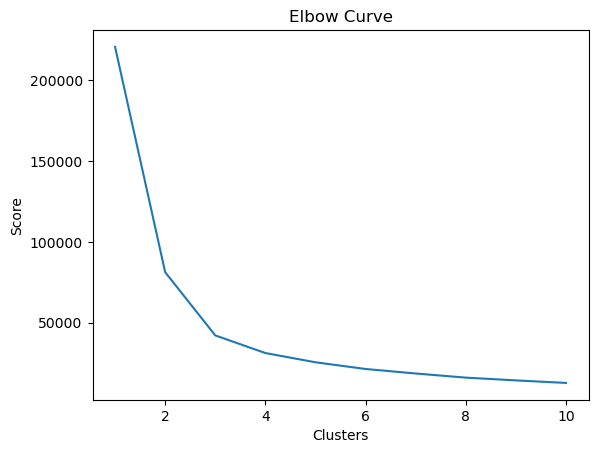

In [485]:
# Perform elbow test
from sklearn.cluster import KMeans
scores = [] # sum of squared distance
cluster_range = range(1,11)

for cluster in cluster_range:
    model_kmeans = KMeans(n_clusters=cluster, init='k-means++', random_state=100)
    model_kmeans.fit(testing_df)
    scores.append(model_kmeans.inertia_)
    
plt.plot(cluster_range, scores)
plt.title('Elbow Curve')
plt.xlabel('Clusters')
plt.ylabel('Score')
plt.show

We will use 3 as the optimal number of clusters

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


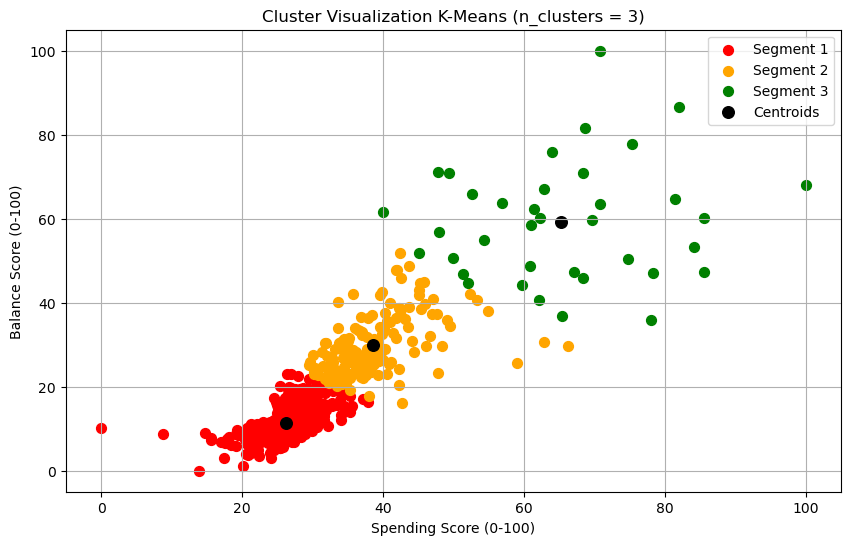

In [488]:
# Testing using kmeans
model_kmeans = KMeans(n_clusters=3, init='k-means++', random_state=100)
clusters = model_kmeans.fit_predict(testing_df)

# Plotting
plt.figure(figsize=(10, 6))
colors = ['orange', 'red', 'green']
labels = ['Segment 2', 'Segment 1', 'Segment 3']
order = [1, 0, 2] # correct order for plotting

for i in order: 
    cluster_data = testing_df.loc[clusters == i]
    plt.scatter(cluster_data['spending_score'], cluster_data['balance_score'], s=50, c=colors[i], label=labels[i])

centroids = model_kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], s=70, c='black', marker='o', label='Centroids')

plt.title('Cluster Visualization K-Means (n_clusters = 3)')
plt.xlabel('Spending Score (0-100)')
plt.ylabel('Balance Score (0-100)')
plt.legend()
plt.grid(True)
plt.show()

In [487]:
# Add cluster results to summary dataframe
account_summary_df['cluster_labels'] = clusters
account_summary_df['cluster_labels'] = account_summary_df['cluster_labels'].replace({0: 1, 1: 0}) # swap order
account_summary_df.head(20)

,income,average_balance,total_spend,avg_monthly_income,avg_monthly_spend,income_spend_ratio,spending_score,balance_score,cluster_labels
account_no,,,,,,,,,
101531259,16967.5,249.857649,16607.60,1542.500000,1509.781818,1.021671,28.019052,9.284177,0
104832000,18875.0,-1162.868456,24218.46,1715.909091,2201.678182,0.779364,21.373857,4.846957,0
105375973,9900.0,108.458303,10027.60,900.000000,911.600000,0.987275,27.075760,8.840057,0
106601471,18425.0,6728.054256,7623.75,1675.000000,693.068182,2.416790,66.279818,29.631492,1
108481285,25104.0,6753.915951,14933.84,2282.181818,1357.621818,1.681014,46.101376,29.712721,1
108563213,41239.0,16282.210888,16225.51,3749.000000,1475.046364,2.541615,69.703122,59.640065,2
108812033,9130.0,881.607670,9632.34,830.000000,875.667273,0.947849,25.994498,11.268436,0
108931112,53519.0,10627.305387,37132.04,4865.363636,3375.640000,1.441316,39.527709,41.878619,1
113747882,28425.0,8752.771757,15885.56,2584.090909,1444.141818,1.789361,49.072751,35.990911,1


In [489]:
testing_df.to_csv("testing_dataset_results.csv")